In [2]:
from pyspark.sql import SparkSession

### initializing spark session

In [3]:
spark = SparkSession.builder.appName('my_app').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/29 16:49:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### reading the data

In [4]:
file_loc = "/kaggle/input/phone-data/phone_price.csv"
data = spark.read.csv(file_loc,header=True,inferSchema=True)

In [5]:
data.show(5)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
|          563|   1|        0.5|       1|  2|     1|        41|  0.9|      145|      5|  6|     1263|    1716|2603|  11|   2|     

In [6]:
data.columns

['battery_power',
 'blue',
 'clock_speed',
 'dual_sim',
 'fc',
 'four_g',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'three_g',
 'touch_screen',
 'wifi',
 'price_range']

### selecting useful columns

In [8]:
data = data.select(['ram','battery_power','px_width','px_height','price_range'])

In [9]:
data.show(5)

+----+-------------+--------+---------+-----------+
| ram|battery_power|px_width|px_height|price_range|
+----+-------------+--------+---------+-----------+
|2549|          842|     756|       20|          1|
|2631|         1021|    1988|      905|          2|
|2603|          563|    1716|     1263|          2|
|2769|          615|    1786|     1216|          2|
|1411|         1821|    1212|     1208|          1|
+----+-------------+--------+---------+-----------+
only showing top 5 rows



### overall info. of the data

In [10]:
data.printSchema()

root
 |-- ram: integer (nullable = true)
 |-- battery_power: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- price_range: integer (nullable = true)



### checking for duplicates

In [11]:
from pyspark.sql import functions as F
duplicate_count = data.groupBy(data.columns).count().filter(F.col('count') > 1).count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### statistical summary of the data

In [12]:
data.describe().show()

24/07/29 16:53:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+-----------------+------------------+------------------+
|summary|               ram|    battery_power|         px_width|         px_height|       price_range|
+-------+------------------+-----------------+-----------------+------------------+------------------+
|  count|              2000|             2000|             2000|              2000|              2000|
|   mean|          2124.213|        1238.5185|        1251.5155|           645.108|               1.5|
| stddev|1084.7320436099492|439.4182060835313|432.1994469463379|443.78081080643824|1.1183136021064597|
|    min|               256|              501|              500|                 0|                 0|
|    max|              3998|             1998|             1998|              1960|                 3|
+-------+------------------+-----------------+-----------------+------------------+------------------+



### checking for null values

In [13]:
null_counts = data.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in data.columns])
null_counts.show()


+---+-------------+--------+---------+-----------+
|ram|battery_power|px_width|px_height|price_range|
+---+-------------+--------+---------+-----------+
|  0|            0|       0|        0|          0|
+---+-------------+--------+---------+-----------+



In [14]:
data.count()

2000

In [15]:
num_cols = ['ram','battery_power','px_width','px_height']
for col in num_cols:
    max_value = data.agg(F.max(col)).collect()[0][0]
    min_value = data.agg(F.min(col)).collect()[0][0]
    print(f"Maximum and minimum value for {col} is {max_value} and {min_value} respectively")
    print('='*30)

Maximum and minimum value for ram is 3998 and 256 respectively
Maximum and minimum value for battery_power is 1998 and 501 respectively
Maximum and minimum value for px_width is 1998 and 500 respectively
Maximum and minimum value for px_height is 1960 and 0 respectively


In [16]:
data.groupBy('price_range').count().orderBy(F.desc('count')).show()

+-----------+-----+
|price_range|count|
+-----------+-----+
|          1|  500|
|          3|  500|
|          2|  500|
|          0|  500|
+-----------+-----+



### check and remove outliers where possible

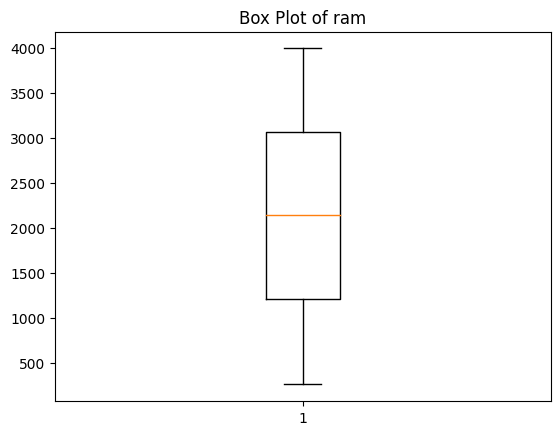

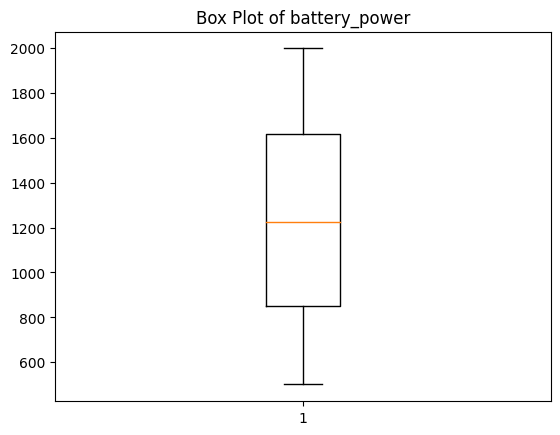

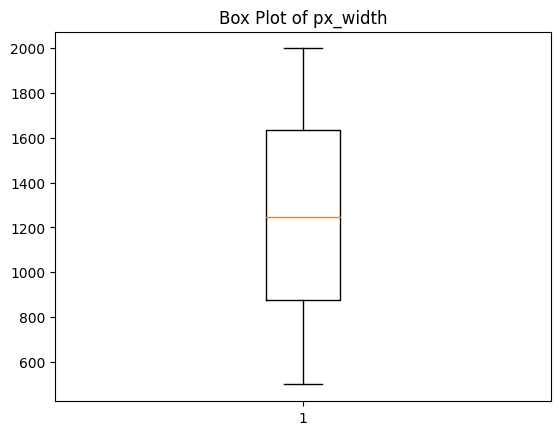

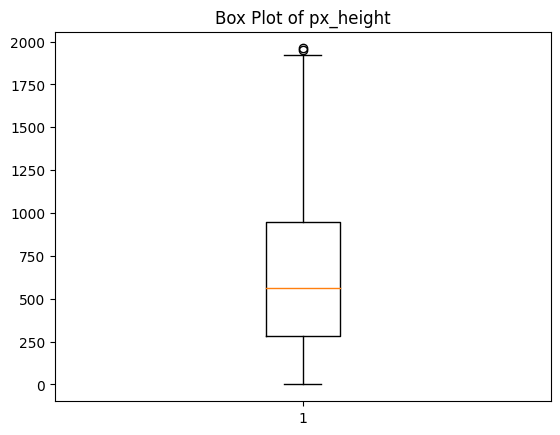

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = data.toPandas()
for col in num_cols:
    plt.boxplot(pandas_df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

In [18]:
quantiles = data.approxQuantile('px_height', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data = data.filter((F.col('px_height') >= lower_bound) & (F.col('px_height') <= upper_bound))

data.count()

1993

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### we need to make our input vars. in form of a list

In [20]:
assembler = VectorAssembler(
    inputCols=['ram','battery_power','px_width','px_height'],
    outputCol='ind_features'
)

In [21]:
new_data = assembler.transform(data)

In [22]:
new_data.show(5)

+----+-------------+--------+---------+-----------+--------------------+
| ram|battery_power|px_width|px_height|price_range|        ind_features|
+----+-------------+--------+---------+-----------+--------------------+
|2549|          842|     756|       20|          1|[2549.0,842.0,756...|
|2631|         1021|    1988|      905|          2|[2631.0,1021.0,19...|
|2603|          563|    1716|     1263|          2|[2603.0,563.0,171...|
|2769|          615|    1786|     1216|          2|[2769.0,615.0,178...|
|1411|         1821|    1212|     1208|          1|[1411.0,1821.0,12...|
+----+-------------+--------+---------+-----------+--------------------+
only showing top 5 rows



In [23]:
final_df = new_data.select('ind_features','price_range')
final_df.show(5)

+--------------------+-----------+
|        ind_features|price_range|
+--------------------+-----------+
|[2549.0,842.0,756...|          1|
|[2631.0,1021.0,19...|          2|
|[2603.0,563.0,171...|          2|
|[2769.0,615.0,178...|          2|
|[1411.0,1821.0,12...|          1|
+--------------------+-----------+
only showing top 5 rows



### train test split

In [24]:
train_df,test_df = final_df.randomSplit([0.75,0.25])

### model building

In [25]:
rf_model = RandomForestClassifier(featuresCol='ind_features', labelCol='price_range', numTrees=10)
classifier = rf_model.fit(train_df)

### prediction on test set, and model evaluation

In [26]:
pred = classifier.transform(test_df)

# model evaluation
evaluator = MulticlassClassificationEvaluator(
    labelCol='price_range', 
    predictionCol='prediction', 
    metricName='accuracy'
)

# Evaluate the model
acc = evaluator.evaluate(pred)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.86


In [27]:
predresults = classifier.evaluate(test_df)

In [29]:
predresults.predictions.show(10)

+--------------------+-----------+--------------------+--------------------+----------+
|        ind_features|price_range|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|[291.0,1146.0,583...|          0|[9.49278680511562...|[0.94927868051156...|       0.0|
|[292.0,742.0,1288...|          0|[9.50775174932585...|[0.95077517493258...|       0.0|
|[296.0,1617.0,142...|          0|[7.83866571344168...|[0.78386657134416...|       0.0|
|[298.0,1969.0,756...|          0|[7.92882672934174...|[0.79288267293417...|       0.0|
|[305.0,503.0,1291...|          0|[9.54411416924991...|[0.95441141692499...|       0.0|
|[311.0,1177.0,882...|          0|[9.49278680511562...|[0.94927868051156...|       0.0|
|[313.0,1194.0,509...|          0|[9.49278680511562...|[0.94927868051156...|       0.0|
|[315.0,1969.0,764...|          0|[8.66531321582822...|[0.86653132158282...|       0.0|
|[324.0,1650.0,881...|          

### saving the model

In [30]:
classifier.save("/kaggle/working/sparkmodel")

### making prediction on new data

In [33]:
from pyspark.ml.linalg import Vectors
inp = [2549,842,756,20]
vector = Vectors.dense(inp)

In [35]:
input_df = spark.createDataFrame([(vector, )], ["ind_features"])
predictions = classifier.transform(input_df)
predictions.show()

+--------------------+--------------------+--------------------+----------+
|        ind_features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[2549.0,842.0,756...|[0.07317073170731...|[0.00731707317073...|       2.0|
+--------------------+--------------------+--------------------+----------+



### stopping the session

In [39]:
spark.stop()